# 1. Import packages

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import data
import skimage
from skimage.filters.thresholding import threshold_li,threshold_local,threshold_otsu
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, remove_small_objects, ball
from skimage.morphology import disk
from scipy import ndimage as ndi
import sys,os, glob

#import skimage.filters.median

#import skimage.segmentation as seg
#import skimage.filters as filters
#import skimage.draw as draw
#import skimage.color as color

#from skimage.filters.thresholding import _cross_entropy
#from skimage.morphology import black_tophat, skeletonize, convex_hull_image


#pip install nd2reader_required for nd2 file reading
from nd2reader import ND2Reader

import pandas as pd

In [5]:
import cellpose
from cellpose import models

In [6]:
from tqdm import tqdm

# 2. Define data parameters

In [7]:
# Common parameters for loading the image files of interest

# for 4 channels nd2 images: channel index order is 1-2-3-4, which is the order as ch405-ch488-ch560-ch647


# analysis done
num_of_ch = 3

# Replace protein/dna label name in the "xxx" below for the indicated channel index (make sure the order is correct)
# For example: ch_dict = {"dna":1,"rpa/rpa2":2,"mdc1":3,"pol2S5":4} if rpa/rpa2 was used for ch488
# Make sure the label name is the same as the factor/dna key used in the line below
ch_dict = {"dna":1,"Mdc1":2,"other":3}

# If use mdc1 as the factor for region segementation
# If use dna/dapi as the key channel for nucleus segmentation
mdc1_key =  "Mdc1"
dna_key = 'dna'  # temporary fix since DNA is not good
other_key="other"

# Whether to analyze the sub-area masks defined by the second marker within the first marker (e.g., h2ax within the mdc) 
analyze_ch_for_2nd_marker_dict = {1:True,2:True,3:False}

# Replace the data directory in the ""; * is the final path level where images are located
# For example: data_save_folder = r"F:\XXX\AAA\BBB\*"

# define well here
# candidate wells: 3, 4, 5, 6, 7
#well_name = 'well3' # done
#well_name = 'well4' #done
#well_name = 'well5' #done
#well_name = 'well6' #done
#well_name = 'well7' #done


############################# CHANGE WELL FOR DATA OF INTEREST ABVOE!##########################################

############################# CHANGE WELL FOR DATA OF INTEREST BELOW!##########################################
data_output_folder = r"D:\Analyzed_CellBio\Stam\40x_MNbody_analysis\220609IF_210502exp_p53ko_fixed_40x\220502_p53ko_4days"
data_main_folder =os.path.join(data_output_folder, '*')
############################# CHANGE WELL FOR DATA OF INTEREST HERE!##########################################



data_input_folder = data_main_folder
data_files = [file for file in glob.glob(data_input_folder) if file[-3:]=="nd2"]

data_files

['D:\\Analyzed_CellBio\\Stam\\40x_MNbody_analysis\\220609IF_210502exp_p53ko_fixed_40x\\220502_p53ko_4days\\220502 RPE1 p53ko noco 4d aMDC1rb-488 H3K27ac-561_005.nd2']

In [8]:
# analyze all ND file or not
# also used as bool setting for adjusting code indendation between different pipelines
_analyze_all_nd = True
#_analyze_all_nd = True

# print progress
_verbose = True

# bad fovs to exclude (e.g., out of focus nd file) if analyze all nd file
# {nd_file_index : [fov_indexes]}
if _analyze_all_nd:
    #fov_to_exclude_dict = {1:[4,5],5:[2,3]}
    fov_to_exclude_dict = {1:[16]}
    

# The pixel size for excluding small 53BP_body;
# Replace *300* with other number desired or *0* if do not want to perform 53BP1 body foci exclusion durng analysis
# Desired foci exclusion can still be performed post-hoc in the resulting dataframe after analysis
# use 200 for 40x images
small_53BP_size = 200

# Other parameteres for image analysis
# border pixel removal for h2ax (or other markers within sub-mdc1 area) positive or less-positive area
h2ax_border_size_filter = 1

# aproximate size for each cell (nuclei)
nuclei_filter = 1000

# for removing tiny nucleoli areas
small_nucleoli_dirt = 10

# erosion factor for dna segmenation
erosion_factor_dna = 5


# std ratio for positive mdc or h2ax, etc calling
h2ax_std_ratio = 3
mdc_std_ratio = 2

# if analyze cell of interest based on annotation:
# the approx distance radius range between the given center and the segmenated center
coord_dist = 100
# if if perform image cropping covering the cell of interest or not
crop_image =  True
raw_image_size = [2048,2048]

# if adjust the focal plane using a smaller crop range than the range used for actual analysis (aka cell size)
narrow_adjust = True
# define the narrowed ratio of the initial crop
narrow_ratio = 0.1


# if re-adjust the focal plane based on cell of interest
adjust_z_for_cell = False


# the cropped image size if performing image cropping covering the cell of interest
cell_size =400

# the percentile for Pol2 to segment the nucleoli area
po2_neg_percentile = 10

# use DAPI channel to do nuclei segmentation or not
use_dna_nuclei = True # shall be good since local dapi in the center is okay

# the alternative channel key if using other channel for nuclei segmentation
if not use_dna_nuclei:
    dna_key = pol2_key
    
    
# specify the region from the whole fov where analysis would be performed
search_xylim = [0,2048]  # Note that DNA channel from the data often is not evenly illuminated


# if save the cropped raw images or not
save_crop_raw_image = True



# 3. Analyze data

In [9]:
# Initiate result dataframe to store analysis measurement:
measurement_for_all_fov_df = pd.DataFrame()


# Initiate cellpose model
model= models.Cellpose(gpu=False, model_type='nuclei',)
####################################################################################
# Loop through each ND data file
for data_ind, data in enumerate(data_files[:]):

    # data name: usually the experiment name 
    data_name = data.split('\\')[-1]

    # if use annotation, then check if data/exp name is in the annotation dict
    if not _analyze_all_nd:
        if data_name in cell_info_dict.keys():
            if _verbose:
                print(f"-----------------------------------------------------------")    
                print(f"-- Start analyzing the dataset of {data_name}")
            # load data if ND data exists in the anntation
            images = ND2Reader(data)
            num_of_planes = images.sizes["z"] # load 'z' info
            # multi-fov image
            if 'v' in images.sizes.keys():
                num_of_fov = images.sizes["v"] # load 'v' info
            # set num_of_fov as 1 for single fov image
            else:
                num_of_fov = 1
        
            # load fov_of_interest from the preprocessed cell_info_dict
            fov_of_interest_str = cell_info_dict[data_name].keys()
            fov_of_interest = [(int(_fov_str)-1) for _fov_str in fov_of_interest_str]
            #print(fov_of_interest)
        else:
            fov_of_interest = []
                    
    # load data without using annotation
    else:
        images = ND2Reader(data)
        num_of_planes = images.sizes["z"] # load 'z' info
        # multi-fov image
        if 'v' in images.sizes.keys():
            num_of_fov = images.sizes["v"] # load 'v' info
        # set num_of_fov as 1 for single fov image
        else:
            num_of_fov = 1
            
        # if exclude bad focal plane that are not focused
        fovs_all = list(range(num_of_fov))
        if data_ind in fov_to_exclude_dict.keys():
            fov_of_interest = [ind for ind in fovs_all if ind not in fov_to_exclude_dict[data_ind]]
        else:
            fov_of_interest = fovs_all
            
###########################################################################################
# Loop through each FOV of interest
    if _verbose:# for indentation purposes
        
        for _fov_id in tqdm(fov_of_interest[:]):                
            
            # use annotation dict to look for cell of interest
            if not _analyze_all_nd:
                if _verbose:
                    print ('-- Use given annotation dict to find cells.')
                cell_coord_list = cell_info_dict[data_name][str(_fov_id+1)] 
            
            # use 3D nuclei signal to do segmenation by cellpose
            else:
                if _verbose:
                    print ('-- Generate 3D nuclei segmentation to find cells.')
                image_cell_3d = []
                for _lyr in range(num_of_planes): # ch index starts from 0
                    image_cell = np.array(images.get_frame_2D (v=_fov_id, c= ch_dict[dna_key]-1, z=_lyr))
                    image_cell_3d.append(image_cell)
                image_cell_3d = np.array(image_cell_3d)
                #
                nuclei_mask_3d,flows, styles, diams = model.eval(image_cell_3d, diameter=90, 
                                                    channels = [0,0],
                                                   flow_threshold=1, do_3D=False)
                
                noncell_mask_all = nuclei_mask_3d==0
                
                # remove edge cell
                nuclei_mask_3d=cellpose.utils.remove_edge_masks(nuclei_mask_3d, change_index=True)
                nuclei_mask_3d=cellpose.utils.fill_holes_and_remove_small_masks(nuclei_mask_3d, min_size=nuclei_filter)
                
                mask_save_path = data_output_folder + os.sep + f'segmentations_{mdc_std_ratio}_{small_53BP_size}_crop_subset_controlled' +  os.sep + \
                        f'{data_name}' +os.sep + f'_Pos_{_fov_id+1}'
                if not os.path.exists(mask_save_path):
                    os.makedirs(mask_save_path)
                mask_name = f'Nuclei_segmenations_exclude_edges_Pos_{_fov_id+1}.tif'
                if os.path.exists(mask_save_path+os.sep+mask_name):
                    os.remove(mask_save_path+os.sep+mask_name)
                io.imsave(mask_save_path+os.sep+mask_name,(skimage.img_as_ubyte(nuclei_mask_3d)), check_contrast=False)
                
                #print(num_of_nuclei)
                # if use the cell coord refined analysis
                cell_coord_list  = []
                for i in np.unique(nuclei_mask_3d)[:]:
                    if i >0:
                        # initate dict to store result
                        measurement_each_dict = {}
                        _cell_id=i
                        cand_nucleus = nuclei_mask_3d == i
                        cand_nucleus[cand_nucleus>0]=1
                        cand_nucleus = np.array(cand_nucleus)
                        # append the coord for the objects of interest
                        region = skimage.measure.regionprops (skimage.measure.label(cand_nucleus))[0]
                        # centroid coord as YX, select the cells within the predefined bound
                        check_Y_pos = region.centroid[0] >= search_xylim[0] and region.centroid[0] <= search_xylim[1]
                        check_X_pos = region.centroid[1] >= search_xylim[0] and region.centroid[1] <= search_xylim[1]
                        if check_Y_pos and check_X_pos:
                            cell_center = [int(region.centroid[1]),int(region.centroid[0])]
                            cell_coord_list.append(cell_center)
                            if _verbose:
                                print (f'-- Processing Cell#{_cell_id} from the image')

                            # define as nuclei mask
                            nuclei_to_measure = cand_nucleus
                            noncell_background = noncell_mask_all

                            # Find the best focal plane using the m6T/mdc (the factor key) channel for the cell of interest  
                            #image_fl = []
                            image_std = []
                            image_3d_for_label = []

                            for _lyr in range(num_of_planes): # ch index starts from 0
                                image_array_fl = np.array(images.get_frame_2D (v=_fov_id, c= ch_dict[mdc1_key]-1, z=_lyr))                  
                                # do cropping if necessary; remember to inver XY
                                if crop_image: # current crop size as rough cell size
                                    crop_y1 = int(max(0,cell_center[1]-cell_size/2))
                                    crop_y2 = int(min(raw_image_size[1],cell_center[1]+cell_size/2))
                                    crop_x1 = int(max(0,cell_center[0]-cell_size/2))
                                    crop_x2 = int(min(raw_image_size[0],cell_center[0]+cell_size/2))
                                    image_array_fl = image_array_fl[crop_y1:crop_y2,crop_x1:crop_x2]


                                 # use image signal STD distribution to find the best focal plane for the plane of interest
                                _fl=image_array_fl.flatten()
                                image_std.append(np.std(_fl))
                                #also append the image for later potential usage (eg. re-adjust focal plane)
                                #image_3d_for_label.append(image_array_fl)

                            # find the initial best focal plane using std features          
                            best_plane_index = np.argmax(np.array(image_std))
                            if _verbose:
                                print(f"-- Analyzing the plane {best_plane_index+1} in fov {_fov_id+1}.")
                            sel_img = np.array(images.get_frame_2D (v=_fov_id, c= ch_dict[mdc1_key]-1, z=best_plane_index))                  

                            if crop_image: # current crop size as rough cell size
                                sel_img = sel_img[crop_y1:crop_y2,crop_x1:crop_x2]
                                nuclei_to_measure = nuclei_to_measure[crop_y1:crop_y2,crop_x1:crop_x2]
                                noncell_background = noncell_background[crop_y1:crop_y2,crop_x1:crop_x2]


                            # Get cellular mdc mask 
                            mdc_intensity = sel_img*nuclei_to_measure
                            mdc_intensity_filtered = mdc_intensity[mdc_intensity!=0]
                            mdc_positive_th =np.mean(mdc_intensity_filtered) + np.std(mdc_intensity_filtered)*mdc_std_ratio
                            mdc_mask = np.logical_and(sel_img>mdc_positive_th, nuclei_to_measure)
                            mdc_chr_mask = remove_small_objects(mdc_mask, small_53BP_size,connectivity=1)
                            mdc_chr_mask = ndi.binary_fill_holes(mdc_chr_mask)
                            mdc_chr_mask = dilation(mdc_chr_mask,disk(1))
                            mdc_chr_mask = erosion(mdc_chr_mask,disk(1))

                            # Append info and results for cells of interest
                            measurement_each_dict['exp_name']=data_input_folder.split('\\')[-2]
                            measurement_each_dict['position_id']=f'{data_name}_Pos{_fov_id+1}'
                            measurement_each_dict['cell_id']=int(_cell_id+1)
                            measurement_each_dict['cell_xyz_coord']=[cell_center, best_plane_index+1]

                            measurement_each_dict['mdc1_size']=np.sum(mdc_chr_mask)
                            measurement_each_dict['nucleus_size']=np.sum(nuclei_to_measure)
                            measurement_each_dict['mdc1_relative_size']=np.sum(mdc_chr_mask)/np.sum(nuclei_to_measure)
                            measurement_each_dict['mdc1_mdc1_intensity']=np.mean((sel_img * mdc_chr_mask)[mdc_chr_mask!=0])
                            measurement_each_dict['nucleus_mdc1_intensity']=np.mean((sel_img * nuclei_to_measure)[nuclei_to_measure!=0])
                            measurement_each_dict['noncell_mdc1_intensity']=np.mean((sel_img * noncell_background)[noncell_background!=0])
                            measurement_each_dict['mdc1_mdc1_norm_intensity']=((measurement_each_dict['mdc1_mdc1_intensity']-measurement_each_dict['noncell_mdc1_intensity'])
                                                                               /(measurement_each_dict['nucleus_mdc1_intensity']-measurement_each_dict['noncell_mdc1_intensity']))


                            measurement_for_each_cell_df=pd.DataFrame.from_dict(measurement_each_dict,orient='index').transpose()
                            measurement_for_all_fov_df = pd.concat([measurement_for_all_fov_df,measurement_for_each_cell_df])

                            # Save individual valid mask or image for each cell 
                            mask_file_list = [mdc_chr_mask,nuclei_to_measure,sel_img]
                            mask_savename_list = [f'cell_{_cell_id+1}_cand_MN_body.tif',
                                                  f'cell_{_cell_id+1}_nucleus.tif',
                                                  f'cell_{_cell_id+1}_MDC1_image.tif',]

                            for _name, _file in zip(mask_savename_list,mask_file_list):
                                # remove old ones if exist
                                if os.path.exists(mask_save_path+os.sep+_name):
                                    os.remove(mask_save_path+os.sep+_name)
                                if _name == f'cell_{_cell_id+1}_MDC1_image.tif':
                                    if save_crop_raw_image:
                                        io.imsave(mask_save_path+os.sep+_name,_file, check_contrast=False)
                                    else:
                                        pass
                                else:
                                    io.imsave(mask_save_path+os.sep+_name,(skimage.img_as_ubyte(_file)), check_contrast=False)



                                
# Save excel result
_save_results = True

if _save_results:
    analysis_savename = f'measurement_for_all_fov_background_subtracted_{mdc_std_ratio}_{small_53BP_size}_crop.xlsx'
    #analysis_save_path = data_save_folder[:-2] + os.sep + 'analysis' + os.sep + f'{data_name}' 
    analysis_save_path = data_output_folder + os.sep + 'analysis_subset_controlled' 
    if not os.path.exists(analysis_save_path):
        os.makedirs(analysis_save_path)
    measurement_for_all_fov_df.to_excel(analysis_save_path+os.sep+analysis_savename)
                            
                        

  0%|                                                                                           | 0/75 [00:00<?, ?it/s]

-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 7 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 1.
-- Processing Cell#2 from the image


c:\programdata\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\programdata\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-- Analyzing the plane 7 in fov 1.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 1.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 1.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 1.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 1.
-- Processing Cell#7 from the image


  1%|█                                                                                  | 1/75 [00:27<33:39, 27.30s/it]

-- Analyzing the plane 5 in fov 1.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 13 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 2.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 2.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 2.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 2.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 2.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 2.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 2.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 2.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 2.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 2.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 2.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 2.
-- Processing Cell#13 from the image


  3%|██▏                                                                                | 2/75 [00:59<36:54, 30.34s/it]

-- Analyzing the plane 7 in fov 2.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 8 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 3.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 3.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 3.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 3.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 3.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 3.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 3.
-- Processing Cell#8 from the image


  4%|███▎                                                                               | 3/75 [01:29<36:06, 30.09s/it]

-- Analyzing the plane 5 in fov 3.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 17 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 4.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 4.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 4.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 4.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 4.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 4.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 4.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 4.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 4.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 4.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 4.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 4.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 4.
-- Processing Cell#14 from the image
-- Analyzing the plane 7 in fov 4.
-

  5%|████▍                                                                              | 4/75 [02:08<39:53, 33.71s/it]

-- Analyzing the plane 7 in fov 4.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 21 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#14 from the image
-- Analyzing the plane 7 in fov 5.
-

  7%|█████▌                                                                             | 5/75 [02:54<44:17, 37.97s/it]

-- Analyzing the plane 7 in fov 5.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 28 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#14 from the image
-- Analyzing the plane 7 in fov 6.
-

  8%|██████▋                                                                            | 6/75 [03:51<51:05, 44.43s/it]

-- Analyzing the plane 7 in fov 6.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 32 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 7.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 7.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 7.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 7.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 7.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 7.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 7.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 7.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 7.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 7.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 7.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 7.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 7.
-- Processing Cell#14 from the image
-- Analyzing the plane 7 in fov 7.
-

  9%|███████▋                                                                           | 7/75 [04:52<56:35, 49.94s/it]

-- Analyzing the plane 7 in fov 7.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 8.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 8.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 8.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 8.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 8.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 8.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 8.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 8.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 8.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 8.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 8.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 8.
-- Processing Cell#13 from the image
-- Analyzing the plane 

 11%|████████▋                                                                        | 8/75 [05:55<1:00:13, 53.93s/it]

-- Analyzing the plane 7 in fov 8.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 27 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 9.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 9.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 9.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 9.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 9.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 9.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 9.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 9.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 9.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 9.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 9.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 9.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 9.
-- Processing Cell#14 from the image
-- Analyzing the plane 7 in fov 9.
-

 12%|█████████▋                                                                       | 9/75 [06:51<1:00:15, 54.78s/it]

-- Analyzing the plane 7 in fov 9.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 35 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 10.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 10.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 10.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 10.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 10.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 10.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 10.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 10.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 10.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 10.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 10.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 10.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 10.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 13%|██████████▋                                                                     | 10/75 [07:54<1:02:03, 57.28s/it]

-- Analyzing the plane 6 in fov 10.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 16 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 11.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 11.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 11.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 11.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 11.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 11.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 11.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 11.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 11.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 11.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 11.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 11.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 11.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 15%|████████████                                                                      | 11/75 [08:38<56:36, 53.08s/it]

-- Analyzing the plane 6 in fov 11.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 31 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 12.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 12.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 12.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 12.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 12.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 12.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 12.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 12.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 12.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 12.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 12.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 12.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 12.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 16%|█████████████                                                                     | 12/75 [09:36<57:18, 54.57s/it]

-- Analyzing the plane 7 in fov 12.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 24 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 13.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 13.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 13.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 13.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 13.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 13.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 13.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 13.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 13.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 13.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 13.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 13.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 13.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 17%|██████████████▏                                                                   | 13/75 [10:28<55:35, 53.80s/it]

-- Analyzing the plane 7 in fov 13.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 19 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 14.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 14.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 14.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 14.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 14.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 14.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 14.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 14.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 14.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 14.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 14.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 14.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 14.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 19%|███████████████▎                                                                  | 14/75 [11:15<52:51, 52.00s/it]

-- Analyzing the plane 6 in fov 14.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 23 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 15.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 15.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 15.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 15.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 15.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 15.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 15.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 15.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 15.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 15.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 15.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 15.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 15.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 20%|████████████████▍                                                                 | 15/75 [12:07<51:54, 51.91s/it]

-- Analyzing the plane 6 in fov 15.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 26 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 16.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 16.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 16.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 16.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 16.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 16.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 16.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 16.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 16.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 16.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 16.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 16.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 16.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 21%|█████████████████▍                                                                | 16/75 [13:02<51:49, 52.70s/it]

-- Analyzing the plane 5 in fov 16.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 29 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 23%|██████████████████▌                                                               | 17/75 [14:01<52:55, 54.74s/it]

-- Analyzing the plane 7 in fov 17.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 18.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 18.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 18.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 18.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 18.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 18.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 18.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 18.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 18.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 18.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 18.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 18.
-- Processing Cell#13 from the image
-- Analyzi

 24%|███████████████████▋                                                              | 18/75 [14:52<50:55, 53.60s/it]

-- Analyzing the plane 7 in fov 18.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 19.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 19.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 19.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 19.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 19.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 19.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 19.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 19.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 19.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 19.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 19.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 19.
-- Processing Cell#13 from the image
-- Analyzi

 25%|████████████████████▊                                                             | 19/75 [15:41<48:45, 52.25s/it]

-- Analyzing the plane 7 in fov 19.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 20.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 20.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 20.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 20.
-- Processing Cell#13 from the image
-- Analyzi

 27%|█████████████████████▊                                                            | 20/75 [16:37<48:55, 53.38s/it]

-- Analyzing the plane 6 in fov 20.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 21.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 21.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 21.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 21.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 21.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 21.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 21.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 21.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 21.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 21.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 21.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 21.
-- Processing Cell#13 from the image
-- Analyzi

 28%|██████████████████████▉                                                           | 21/75 [17:32<48:26, 53.83s/it]

-- Analyzing the plane 6 in fov 21.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 22.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 22.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 22.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 22.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 22.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 22.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 22.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 22.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 22.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 22.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 22.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 22.
-- Processing Cell#13 from the image
-- Analyzi

 29%|████████████████████████                                                          | 22/75 [18:17<45:04, 51.03s/it]

-- Analyzing the plane 5 in fov 22.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 15 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 23.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 23.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 23.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 23.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 23.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 23.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 23.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 23.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 23.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 23.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 23.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 23.
-- Processing Cell#13 from the image
-- Analyzing the plane 5 in fov 23.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 31%|█████████████████████████▏                                                        | 23/75 [18:59<42:04, 48.54s/it]

-- Analyzing the plane 6 in fov 23.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 24.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 24.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 24.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 24.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 24.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 24.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 24.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 24.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 24.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 24.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 24.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 24.
-- Processing Cell#13 from the image
-- Analyzi

 32%|██████████████████████████▏                                                       | 24/75 [19:45<40:27, 47.60s/it]

-- Analyzing the plane 6 in fov 24.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 25.
-- Processing Cell#2 from the image
-- Analyzing the plane 5 in fov 25.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 25.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 25.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 25.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 25.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 25.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 25.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 25.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 25.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 25.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 25.
-- Processing Cell#13 from the image
-- Analyzi

 33%|███████████████████████████▎                                                      | 25/75 [20:30<39:05, 46.91s/it]

-- Analyzing the plane 5 in fov 25.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 5 in fov 26.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 26.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 26.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 26.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 26.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 26.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 26.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 26.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 26.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 26.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 26.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 26.
-- Processing Cell#13 from the image
-- Analyzi

 35%|████████████████████████████▍                                                     | 26/75 [21:30<41:27, 50.78s/it]

-- Analyzing the plane 5 in fov 26.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 27.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 27.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 27.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 27.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 27.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 27.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 27.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 27.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 27.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 27.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 27.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 27.
-- Processing Cell#13 from the image
-- Analyzi

 36%|█████████████████████████████▌                                                    | 27/75 [22:15<39:18, 49.14s/it]

-- Analyzing the plane 6 in fov 27.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 28.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 28.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 28.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 28.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 28.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 28.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 28.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 28.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 28.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 28.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 28.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 28.
-- Processing Cell#13 from the image
-- Analyzi

 37%|██████████████████████████████▌                                                   | 28/75 [23:12<40:20, 51.51s/it]

-- Analyzing the plane 6 in fov 28.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 22 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 29.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 29.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 29.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 29.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 29.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 29.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 29.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 29.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 29.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 29.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 29.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 29.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 29.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 39%|███████████████████████████████▋                                                  | 29/75 [24:01<38:55, 50.77s/it]

-- Analyzing the plane 7 in fov 29.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 30.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 30.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 30.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 30.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 30.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 30.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 30.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 30.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 30.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 30.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 30.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 30.
-- Processing Cell#13 from the image
-- Analyzi

 40%|████████████████████████████████▊                                                 | 30/75 [24:56<39:01, 52.03s/it]

-- Analyzing the plane 5 in fov 30.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 31.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 31.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 31.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 31.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 31.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 31.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 31.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 31.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 31.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 31.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 31.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 31.
-- Processing Cell#13 from the image
-- Analyzi

 41%|█████████████████████████████████▉                                                | 31/75 [25:43<37:02, 50.51s/it]

-- Analyzing the plane 6 in fov 31.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 18 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 32.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 32.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 32.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 32.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 32.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 32.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 32.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 32.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 32.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 32.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 32.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 32.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 32.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 43%|██████████████████████████████████▉                                               | 32/75 [26:27<34:48, 48.56s/it]

-- Analyzing the plane 6 in fov 32.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 33.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 33.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 33.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 33.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 33.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 33.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 33.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 33.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 33.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 33.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 33.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 33.
-- Processing Cell#13 from the image
-- Analyzi

 44%|████████████████████████████████████                                              | 33/75 [27:16<34:04, 48.67s/it]

-- Analyzing the plane 6 in fov 33.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 34.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 34.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 34.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 34.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 34.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 34.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 34.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 34.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 34.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 34.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 34.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 34.
-- Processing Cell#13 from the image
-- Analyzi

 45%|█████████████████████████████████████▏                                            | 34/75 [28:04<33:07, 48.48s/it]

-- Analyzing the plane 5 in fov 34.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 35.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 35.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 35.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 35.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 35.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 35.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 35.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 35.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 35.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 35.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 35.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 35.
-- Processing Cell#13 from the image
-- Analyzi

 47%|██████████████████████████████████████▎                                           | 35/75 [29:00<33:46, 50.67s/it]

-- Analyzing the plane 5 in fov 35.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 36.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 36.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 36.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 36.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 36.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 36.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 36.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 36.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 36.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 36.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 36.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 36.
-- Processing Cell#13 from the image
-- Analyzi

 48%|███████████████████████████████████████▎                                          | 36/75 [29:56<33:58, 52.27s/it]

-- Analyzing the plane 7 in fov 36.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#13 from the image
-- Analyzi

 49%|████████████████████████████████████████▍                                         | 37/75 [30:55<34:17, 54.14s/it]

-- Analyzing the plane 7 in fov 37.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 39 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 38.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 38.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 38.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 38.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 38.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 38.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 38.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 38.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 38.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 38.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 38.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 38.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 38.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 51%|█████████████████████████████████████████▌                                        | 38/75 [32:04<36:08, 58.61s/it]

-- Analyzing the plane 5 in fov 38.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 39.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 39.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 39.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 39.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 39.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 39.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 39.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 39.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 39.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 39.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 39.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 39.
-- Processing Cell#13 from the image
-- Analyzi

 52%|██████████████████████████████████████████▋                                       | 39/75 [33:01<34:59, 58.32s/it]

-- Analyzing the plane 6 in fov 39.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 40.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 40.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 40.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 40.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 40.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 40.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 40.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 40.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 40.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 40.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 40.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 40.
-- Processing Cell#13 from the image
-- Analyzi

 53%|███████████████████████████████████████████▋                                      | 40/75 [33:59<33:56, 58.19s/it]

-- Analyzing the plane 6 in fov 40.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 25 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 41.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 41.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 41.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 41.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 41.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 55%|████████████████████████████████████████████▊                                     | 41/75 [34:54<32:23, 57.16s/it]

-- Analyzing the plane 6 in fov 41.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 20 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 42.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 42.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 42.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 42.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 42.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 42.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 42.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 42.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 42.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 42.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 42.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 42.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 42.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 56%|█████████████████████████████████████████████▉                                    | 42/75 [35:43<30:10, 54.87s/it]

-- Analyzing the plane 6 in fov 42.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 43.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 43.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 43.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 43.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 43.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 43.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 43.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 43.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 43.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 43.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 43.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 43.
-- Processing Cell#13 from the image
-- Analyzi

 57%|███████████████████████████████████████████████                                   | 43/75 [36:29<27:42, 51.96s/it]

-- Analyzing the plane 5 in fov 43.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 33 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 44.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 44.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 44.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 44.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 44.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 44.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 44.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 44.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 44.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 44.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 44.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 44.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 44.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 59%|████████████████████████████████████████████████                                  | 44/75 [37:31<28:33, 55.26s/it]

-- Analyzing the plane 5 in fov 44.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 45.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 45.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 45.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 45.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 45.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 45.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 45.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 45.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 45.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 45.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 45.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 45.
-- Processing Cell#13 from the image
-- Analyzi

 60%|█████████████████████████████████████████████████▏                                | 45/75 [38:22<26:53, 53.77s/it]

-- Analyzing the plane 7 in fov 45.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 46.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 46.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 46.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 46.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 46.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 46.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 46.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 46.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 46.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 46.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 46.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 46.
-- Processing Cell#13 from the image
-- Analyzi

 61%|██████████████████████████████████████████████████▎                               | 46/75 [39:12<25:27, 52.66s/it]

-- Analyzing the plane 6 in fov 46.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 47.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 47.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 47.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 47.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 47.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 47.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 47.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 47.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 47.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 47.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 47.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 47.
-- Processing Cell#13 from the image
-- Analyzi

 63%|███████████████████████████████████████████████████▍                              | 47/75 [40:07<24:56, 53.46s/it]

-- Analyzing the plane 7 in fov 47.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 48.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 48.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 48.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 48.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 48.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 48.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 48.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 48.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 48.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 48.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 48.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 48.
-- Processing Cell#13 from the image
-- Analyzi

 64%|████████████████████████████████████████████████████▍                             | 48/75 [41:07<24:56, 55.44s/it]

-- Analyzing the plane 6 in fov 48.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 49.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 49.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 49.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 49.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 49.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 49.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 49.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 49.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 49.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 49.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 49.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 49.
-- Processing Cell#13 from the image
-- Analyzi

 65%|█████████████████████████████████████████████████████▌                            | 49/75 [42:06<24:30, 56.57s/it]

-- Analyzing the plane 6 in fov 49.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 5 in fov 50.
-- Processing Cell#2 from the image
-- Analyzing the plane 5 in fov 50.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 50.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 50.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 50.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 50.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 50.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 50.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 50.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 50.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 50.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 50.
-- Processing Cell#13 from the image
-- Analyzi

 67%|██████████████████████████████████████████████████████▋                           | 50/75 [43:01<23:17, 55.88s/it]

-- Analyzing the plane 5 in fov 50.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 30 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 51.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 51.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 51.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 51.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 51.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 51.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 51.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 51.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 51.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 51.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 51.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 51.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 51.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 68%|███████████████████████████████████████████████████████▊                          | 51/75 [43:58<22:33, 56.38s/it]

-- Analyzing the plane 6 in fov 51.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 37 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 52.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 52.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 52.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 52.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 52.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 52.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 52.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 52.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 52.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 52.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 52.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 52.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 52.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 69%|████████████████████████████████████████████████████████▊                         | 52/75 [45:05<22:48, 59.52s/it]

-- Analyzing the plane 6 in fov 52.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 53.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 53.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 53.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 53.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 53.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 53.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 53.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 53.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 53.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 53.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 53.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 53.
-- Processing Cell#13 from the image
-- Analyzi

 71%|█████████████████████████████████████████████████████████▉                        | 53/75 [45:59<21:12, 57.85s/it]

-- Analyzing the plane 7 in fov 53.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 54.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 54.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 54.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 54.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 54.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 54.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 54.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 54.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 54.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 54.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 54.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 54.
-- Processing Cell#13 from the image
-- Analyzi

 72%|███████████████████████████████████████████████████████████                       | 54/75 [46:41<18:35, 53.13s/it]

-- Analyzing the plane 6 in fov 54.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#13 from the image
-- Analyzi

 73%|████████████████████████████████████████████████████████████▏                     | 55/75 [47:31<17:25, 52.26s/it]

-- Analyzing the plane 7 in fov 55.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 34 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 75%|█████████████████████████████████████████████████████████████▏                    | 56/75 [48:29<17:04, 53.93s/it]

-- Analyzing the plane 7 in fov 56.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 57.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 57.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 57.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 57.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 57.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 57.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 57.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 57.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 57.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 57.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 57.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 57.
-- Processing Cell#13 from the image
-- Analyzi

 76%|██████████████████████████████████████████████████████████████▎                   | 57/75 [49:15<15:25, 51.44s/it]

-- Analyzing the plane 7 in fov 57.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 58.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 58.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 58.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 58.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 58.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 58.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 58.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 58.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 58.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 58.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 58.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 58.
-- Processing Cell#13 from the image
-- Analyzi

 77%|███████████████████████████████████████████████████████████████▍                  | 58/75 [50:03<14:16, 50.39s/it]

-- Analyzing the plane 7 in fov 58.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 36 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 59.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 59.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 59.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 59.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 59.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 59.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 59.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 59.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 59.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 59.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 59.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 59.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 59.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 79%|████████████████████████████████████████████████████████████████▌                 | 59/75 [51:04<14:16, 53.55s/it]

-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 60.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 60.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 60.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 60.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 60.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 60.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 60.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 60.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 60.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 60.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 60.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 60.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 60.
-- Process

 80%|█████████████████████████████████████████████████████████████████▌                | 60/75 [51:57<13:24, 53.62s/it]

-- Analyzing the plane 5 in fov 60.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 40 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 61.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 61.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 61.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 61.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 61.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 61.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 61.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 61.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 61.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 61.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 61.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 61.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 61.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 81%|██████████████████████████████████████████████████████████████████▋               | 61/75 [52:58<13:00, 55.77s/it]

-- Analyzing the plane 6 in fov 61.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#13 from the image
-- Analyzi

 83%|███████████████████████████████████████████████████████████████████▊              | 62/75 [53:50<11:48, 54.50s/it]

-- Analyzing the plane 7 in fov 62.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 63.
-- Processing Cell#2 from the image
-- Analyzing the plane 5 in fov 63.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 63.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 63.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 63.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 63.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 63.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 63.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 63.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 63.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 63.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 63.
-- Processing Cell#13 from the image
-- Analyzi

 84%|████████████████████████████████████████████████████████████████████▉             | 63/75 [54:35<10:22, 51.85s/it]

-- Analyzing the plane 5 in fov 63.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 64.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 64.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 64.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 64.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 64.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 64.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 64.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 64.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 64.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 64.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 64.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 64.
-- Processing Cell#13 from the image
-- Analyzi

 85%|█████████████████████████████████████████████████████████████████████▉            | 64/75 [55:20<09:05, 49.63s/it]

-- Analyzing the plane 7 in fov 64.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 65.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 65.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 65.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 65.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 65.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 65.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 65.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 65.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 65.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 65.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 65.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 65.
-- Processing Cell#13 from the image
-- Analyzi

 87%|███████████████████████████████████████████████████████████████████████           | 65/75 [55:58<07:40, 46.04s/it]

-- Analyzing the plane 6 in fov 65.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 66.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 66.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 66.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 66.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 66.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 66.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 66.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 66.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 66.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 66.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 66.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 66.
-- Processing Cell#13 from the image
-- Analyzi

 88%|████████████████████████████████████████████████████████████████████████▏         | 66/75 [56:46<07:00, 46.70s/it]

-- Analyzing the plane 6 in fov 66.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 67.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 67.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 67.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 67.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 67.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 67.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 67.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 67.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 67.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 67.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 67.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 67.
-- Processing Cell#13 from the image
-- Analyzi

 89%|█████████████████████████████████████████████████████████████████████████▎        | 67/75 [57:23<05:51, 43.98s/it]

-- Analyzing the plane 6 in fov 67.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 68.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 68.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 68.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 68.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 68.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 68.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 68.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 68.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 68.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 68.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 68.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 68.
-- Processing Cell#13 from the image
-- Analyzi

 91%|██████████████████████████████████████████████████████████████████████████▎       | 68/75 [58:21<05:35, 47.93s/it]

-- Analyzing the plane 6 in fov 68.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 53 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 69.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 69.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 69.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 69.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 69.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 69.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 69.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 69.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 69.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 69.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 69.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 69.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 69.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 92%|███████████████████████████████████████████████████████████████████████████▍      | 69/75 [59:29<05:25, 54.17s/it]

-- Analyzing the plane 6 in fov 69.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 70.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 70.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 70.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 70.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 70.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 70.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 70.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 70.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 70.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 70.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 70.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 70.
-- Processing Cell#13 from the image
-- Analyzi

 93%|██████████████████████████████████████████████████████████████████████████▋     | 70/75 [1:00:46<05:04, 60.89s/it]

-- Analyzing the plane 6 in fov 70.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 47 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 71.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 71.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 71.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 71.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 71.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 71.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 71.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 71.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 71.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 71.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 71.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 71.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 71.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 95%|███████████████████████████████████████████████████████████████████████████▋    | 71/75 [1:01:56<04:14, 63.53s/it]

-- Analyzing the plane 7 in fov 71.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 71 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 72.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 72.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 72.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 72.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 72.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 72.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 72.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 72.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 72.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 72.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 72.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 72.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 72.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 96%|████████████████████████████████████████████████████████████████████████████▊   | 72/75 [1:03:30<03:38, 72.70s/it]

-- Analyzing the plane 6 in fov 72.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 46 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 73.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 73.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 73.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 73.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 73.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 73.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 73.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 73.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 73.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 73.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 73.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 73.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 73.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 73/75 [1:04:33<02:19, 69.94s/it]

-- Analyzing the plane 6 in fov 73.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 63 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 74.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 74.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 74.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 74.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 74.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 74.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 74.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 74.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 74.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 74.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 74.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 74.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 74.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 74/75 [1:05:58<01:14, 74.44s/it]

-- Analyzing the plane 6 in fov 74.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 52 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 75.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 75.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 75.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 75.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 75.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 75.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 75.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 75.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 75.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 75.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 75.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 75.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 75.
-- Processing Cell#14 from the image
-- Analyzing the plane 

100%|████████████████████████████████████████████████████████████████████████████████| 75/75 [1:07:02<00:00, 53.64s/it]

-- Analyzing the plane 6 in fov 75.


In [10]:
measurement_for_all_fov_df

,exp_name,position_id,cell_id,cell_xyz_coord,mdc1_size,nucleus_size,mdc1_relative_size,mdc1_mdc1_intensity,nucleus_mdc1_intensity,noncell_mdc1_intensity,mdc1_mdc1_norm_intensity
0,220502_p53ko_4days,220502 RPE1 p53ko noco 4d aMDC1rb-488 H3K27ac-...,2,"[[1724, 458], 7]",0,6806,0.0,NaN,471.819865,139.563664,NaN
0,220502_p53ko_4days,220502 RPE1 p53ko noco 4d aMDC1rb-488 H3K27ac-...,3,"[[1659, 453], 7]",0,1114,0.0,NaN,404.503591,138.862952,NaN
0,220502_p53ko_4days,220502 RPE1 p53ko noco 4d aMDC1rb-488 H3K27ac-...,4,"[[1742, 547], 7]",0,1900,0.0,NaN,462.474211,139.110778,NaN
0,220502_p53ko_4days,220502 RPE1 p53ko noco 4d aMDC1rb-488 H3K27ac-...,5,"[[272, 800], 6]",0,2597,0.0,NaN,763.813631,116.789686,NaN
0,220502_p53ko_4days,220502 RPE1 p53ko noco 4d aMDC1rb-488 H3K27ac-...,6,"[[1334, 1497], 6]",0,5456,0.0,NaN,643.288306,117.761634,NaN
...,...,...,...,...,...,...,...,...,...,...,...
0,220502_p53ko_4days,220502 RPE1 p53ko noco 4d aMDC1rb-488 H3K27ac-...,49,"[[1383, 1935], 6]",0,3866,0.0,NaN,1036.200207,136.418493,NaN
0,220502_p53ko_4days,220502 RPE1 p53ko noco 4d aMDC1rb-488 H3K27ac-...,50,"[[1148, 1940], 6]",0,5798,0.0,NaN,801.192135,140.713438,NaN
0,220502_p53ko_4days,220502 RPE1 p53ko noco 4d aMDC1rb-488 H3K27ac-...,51,"[[89, 1991], 7]",0,3360,0.0,NaN,1434.893155,146.298485,NaN
0,220502_p53ko_4days,220502 RPE1 p53ko noco 4d aMDC1rb-488 H3K27ac-...,52,"[[225, 1994], 6]",0,4434,0.0,NaN,1089.248534,148.665328,NaN


In [11]:
import seaborn as sns

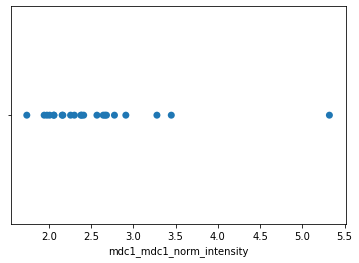

In [12]:
sns.swarmplot(measurement_for_all_fov_df['mdc1_mdc1_norm_intensity'],s=7)

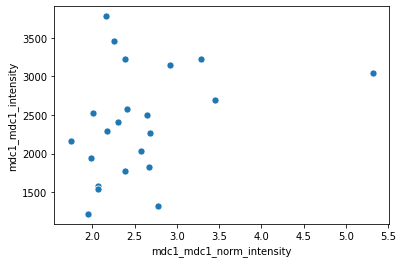

In [13]:
sns.scatterplot(measurement_for_all_fov_df['mdc1_mdc1_norm_intensity'],measurement_for_all_fov_df['mdc1_mdc1_intensity'],s=50)

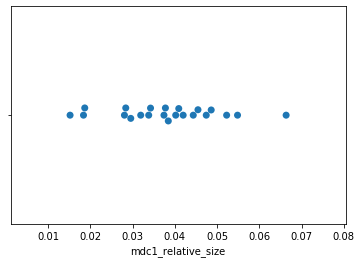

In [14]:
sel_mdc_df = measurement_for_all_fov_df[measurement_for_all_fov_df['mdc1_relative_size']>0]
sns.swarmplot(sel_mdc_df['mdc1_relative_size'],s=7)

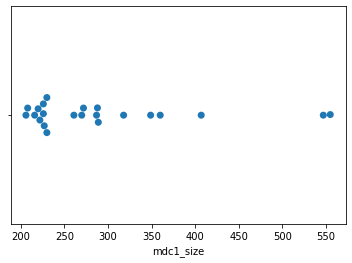

In [15]:
sel_mdc_df = measurement_for_all_fov_df[measurement_for_all_fov_df['mdc1_relative_size']>0]
sns.swarmplot(sel_mdc_df['mdc1_size'],s=7)

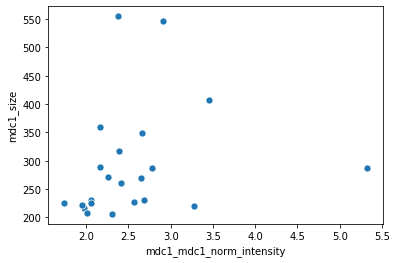

In [16]:
sns.scatterplot(sel_mdc_df['mdc1_mdc1_norm_intensity'],sel_mdc_df['mdc1_size'],s=50)

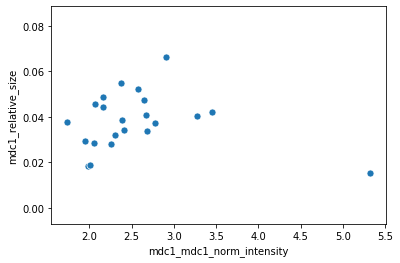

In [17]:
sns.scatterplot(sel_mdc_df['mdc1_mdc1_norm_intensity'],sel_mdc_df['mdc1_relative_size'],s=50)

In [18]:
measurement_for_all_fov_df_filter=measurement_for_all_fov_df[measurement_for_all_fov_df['nucleus_size']>2000]

In [19]:
len(measurement_for_all_fov_df_filter)

1944

In [20]:
len(measurement_for_all_fov_df)

2072

In [21]:
len(sel_mdc_df)

22

In [22]:
len(sel_mdc_df)/len(measurement_for_all_fov_df_filter)

0.01131687242798354

In [23]:
len(sel_mdc_df)/len(measurement_for_all_fov_df)

0.010617760617760617